In [1]:
import pandas as pd
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import numpy as np
from pathlib import Path

In [2]:
datadir = '../Data/'

In [3]:
registered_projects = pd.read_excel(os.path.join(datadir, 'CSV','verra_registry.xlsx'))

In [6]:
registered_projects['Region'].uniqueque()

array(['Middle East', 'Asia', 'Europe', 'Africa', nan, 'Oceania',
       'North America', 'Latin America'], dtype=object)

In [7]:
active_south_america_projects = registered_projects.loc[(registered_projects['Status'] == 'Registered')&(registered_projects['Project Type']=='Agriculture Forestry and Other Land Use')&(registered_projects['Region']=='Latin America')]

In [38]:
active_africa_projects = registered_projects.loc[(registered_projects['Status'] == 'Registered')&(registered_projects['Project Type']=='Agriculture Forestry and Other Land Use')&(registered_projects['Region']=='Africa')]

In [39]:
active_south_america_projects.to_csv('../Data/CSV/active_SouthAmerica_projects.csv')

In [40]:
active_africa_projects.to_csv('active_Africa_projects.csv')

In [41]:
africa_project_ids = active_africa_projects.ID.unique()

In [42]:
africa_project_ids

array([2410, 2401, 2382, 2338, 2339, 2324, 2319, 1071, 1339, 2085, 1900,
       1897, 1052,  829, 1327,  799, 1775,  721,  987,  898, 1674, 1225,
       1311,  993,  995,  899,  824,  825,  826,  827,  737, 1343, 1168,
        562,  934,  142, 1408, 1047, 1340, 1532,  594,  595,  596,  597,
        996, 1325, 1215,  673,  612, 1201, 1318,  902, 1202, 1359,  720])

In [14]:
south_america_project_ids = active_south_america_projects.ID.unique()

In [28]:
import geopandas as gpd
import fiona
fiona.drvsupport.supported_drivers['kml'] = 'rw' # enable KML support which is disabled by default
fiona.drvsupport.supported_drivers['KML'] = 'rw' # enable KML support which is disabled by default

not_work = []

combined = gpd.GeoDataFrame()

for file in os.listdir(os.path.join(datadir,'KML')):
    ids = file.split('_')[0]
    if np.isin(ids, south_america_project_ids) == True:
        try:
            df = gpd.read_file(os.path.join(datadir,'KML', file))
            df['ID'] = ids
            #df.geometry = df.geometry.buffer(0.1)
            if len(combined) == 0:
                combined = df
            else:
                combined = pd.concat([combined, df])
        except:
            print(f'Not working for {file}')
            not_work.append(file)

Not working for 1067_Area_del_proyecto_TAMBOPATA.kml
Not working for 1218_Ubicaci??n_Area_del_proyecto.kml
Not working for 1360_ID 1360.kml
Not working for 2411_Mapa_ubicacion_predios_BDU_II KML.kml
Not working for 796_VCS_KML_0796_22AUG2022.kml
Not working for 818_KML_818_22MAR2012.kml
Not working for 844_Project Area.kml


In [29]:
combined.columns

Index(['Name', 'Description', 'geometry', 'ID'], dtype='object')

In [30]:
combined = combined.drop(columns={'Name', 'Description'})

<AxesSubplot: >

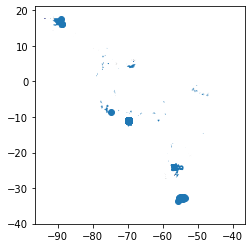

In [31]:
combined.plot()

In [43]:
# Create a GeoDataFrame for Point geometries
points_gdf = combined[combined['geometry'].type == 'Point']

# Save the Point GeoDataFrame to a separate shapefile
points_gdf.to_file(os.path.join(datadir, 'SHP', 'point_geometries.shp'))

# Filter out Point geometries from the original GeoDataFrame
combined = combined[combined['geometry'].type != 'Point']

# Save the modified GeoDataFrame (without Points) to a shapefile
combined.to_file(os.path.join(datadir, 'SHP', 'SouthAmerica_projects.geojson'))

/home/c4ubuntu/anaconda3/lib/python3.9/site-packages/geopandas/io/file.py:545: UserWarning: You are attempting to write an empty DataFrame to file. For some drivers, this operation may fail.
  _to_file_fiona(df, filename, driver, schema, crs, mode, **kwargs)



### Export to disk

In [19]:
from shapely.geometry import Point, Polygon, LineString

# Convert points to polygons by buffering
combined['geometry'] = combined['geometry'].apply(lambda geom: geom.buffer(0.001) if geom.type == 'Point' else geom)
# Convert LineString to Polygon
combined['geometry'] = combined['geometry'].apply(lambda geom: Polygon(geom) if geom.type == 'LineString' else geom)


# Save the modified GeoDataFrame to a shapefile
combined.to_file(os.path.join(datadir, 'SHP', 'south_america_projects.shp'))

/tmp/ipykernel_13702/324471024.py:4: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  combined['geometry'] = combined['geometry'].apply(lambda geom: geom.buffer(0.001) if geom.type == 'Point' else geom)
/tmp/ipykernel_13702/324471024.py:6: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  combined['geometry'] = combined['geometry'].apply(lambda geom: Polygon(geom) if geom.type == 'LineString' else geom)
/tmp/ipykernel_13702/324471024.py:6: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  combined['geometry'] = combined['geometry'].apply(lambda geom: Polygon(geom) if geom.type == 'LineString' else geom)
/tmp/ipykernel_13702/324471024.py:6: ShapelyDeprecationWarning: The 'type' attribute is deprecate

ValueError: A linearring requires at least 4 coordinates.

# Database

In [32]:
methodologies = pd.read_csv(Path(datadir, 'CSV','VCS_Methodology_Dataset_Basic.csv'), sep=';')
methodologies = methodologies[['VCS_Code', 'Name_Long', 'Status', 'Active_Start', 'Activity_type',
       'Eligible_Area', 'Applicable', 'Not_Applicable']]

## Add criteria information

In [45]:
import pandas as pd

data = {
    'VCS_Code': ['VM0042','VM0042','VM0042',
                 'VM0042','VM0042','VM0042',
                 'VM0042','VM0042'],
    'Activity_type': ['ALM', 'ALM', 'ALM', 
                      'ALM','ALM', 'ALM', 
                      'ALM', 'ALM'],
    'Criterion_Type': ['Eligibility', 'Eligibility', 
                       'Eligibility', 'Eligibility', 
                       'Ineligibility', 'Ineligibility',
                       'Ineligibility', 'Ineligibility'],
    'Criterion': [
        'Introduction or implementation of one or more new changes to pre-existing ALM practices.',
        'Projects that introduce or implement quantitative adjustments (e.g., decrease in fertilizer application rate) must exceed five percent of the pre-existing value, calculated as the average value over the historical look-back period.',
        'Project activities must be implemented on land that is either cropland or grassland at the project start date. The land must remain cropland or grassland throughout the project crediting period except under certain scenarios.',
        'Use of empirical or process-based models for estimation.',
        'The project area has been cleared of native ecosystems within the 10-year period immediately prior to the project start date.',
        'The project activity is expected to cause a sustained reduction in productivity of greater than 5 percent, as demonstrated by peer-reviewed and/or published studies on the activity in the region or a comparable region.',
        'The project activity is biochar application. Biochar may be applied as a soil amendment in the project area provided that the total organic carbon content of the biochar applied is subtracted from the estimated SOC stock change in the project scenario at each verification event.',
        'The project activities occur on a wetland; this condition does not exclude crops subject to artificial flooding where it is demonstrated that crop cultivation does not impact the hydrology of any nearby wetlands.'
    ]
}

data_1 = {
    'VCS_Code': ['VM0007', 'VM0007', 'VM0007',
                 'VM0007', 'VM0007', 'VM0007'],
    'Activity_type': ['REDD', 'REDD', 'REDD', 'REDD', 'REDD', 'REDD'],
    'Criterion_Type': ['Eligibility', 'Eligibility', 'Eligibility', 'Eligibility', 'Ineligibility', 'Ineligibility'],
    'Criterion': [
        'Land in the project area has qualified as forest for at least the 10 years prior to the project start date.',
        'Mangrove forests are excluded from any tree height requirement.',
        'If land within the project area is peatland or tidal wetlands and emissions from the SOC pool are deemed significant, the relevant WRC modules must be applied alongside other relevant modules.',
        'Baseline deforestation and forest degradation in the project area fall within one or more of the following categories: Unplanned deforestation, Planned deforestation/degradation, Degradation through extraction of wood for fuel.',
        'Leakage avoidance activities must not include agricultural lands that are flooded to increase production (e.g., rice paddy).',
        'Intensifying livestock production through the use of feed-lots and/or manure lagoons.'
    ]
}

data_2 = {
    'VCS_Code': ['VM0009','VM0009',
                 'VM0009','VM0009',
                 'VM0009','VM0009',
                 'VM0009','VM0009',
                 'VM0009','VM0009',
                 'VM0009','VM0009',
                 'VM0009','VM0009',
                 'VM0009'],
    'Activity_type': ['REDD','REDD',
                      'REDD','REDD',
                      'REDD','REDD',
                      'REDD','REDD',
                      'REDD','REDD',
                      'REDD','REDD',
                      'REDD','REDD',
                     'REDD'],
    'Criterion_Type': ['Eligibility','Eligibility','Eligibility','Eligibility','Eligibility','Eligibility',
                       'Eligibility',
                       'Eligibility','Eligibility','Eligibility','Eligibility','Eligibility','Eligibility',
                       'Ineligibility', 'Ineligibility'],
    'Criterion': [
        # Elegibility
        'The drivers and agents of conversion in the baseline scenario must be consistent with those described in section 6 of this methodology.',
        'The end land use in the baseline scenario is non-forest.',
        'The project activity must be APD or AUDD.',
        'The land must have been in an unconverted state (forest) for at least 10 years prior to the project start date.',
        "For project accounting areas with an unplanned baseline type, a conversion threat must exist.",
        "In the case of baseline type F-U1, at least 25% of the project area boundary must be within 120 meters of deforestation and at least 25% must be adjacent to the reference area.",
        "In the case of baseline type F-U2, at least 25% of the project area boundary must be within 120 meters of deforestation.",
        "The project accounting area must not contain peat soil.",
        "A reference area can be delineated for each baseline type in the baseline scenario that meets the requirements of section 6.8.1.",
        "Historic imagery of the reference area(s) must exist with sufficient coverage to meet the requirements of section 6.8.4.",
        "Project activities are planned or implemented to mitigate ecosystem conversion by addressing the agents and drivers of conversion.",
        "The project proponent must have access to the activity-shifting leakage area(s) and proxy area(s) for monitoring or must have access to monitoring data from these areas for every monitoring event.",
        "If logging is included in the baseline scenario and a market leakage area is required, the project proponent must have access to monitoring data from the market leakage area.",
        # Ineligibility
        "If the project is located in a non-tropical ecosystem and SOC is a selected carbon pool with the default value from section 6.19.2, then the project is not applicable.",
        "If livestock are being grazed within the project area in the project scenario and there is manure management taking place."    
    ]
}

data_3 = {
    'VCS_Code': ['ARR', 'ARR','ARR',
                 'ARR','ARR', 'ARR'],
    'Activity_type': ['ARR', 'ARR','ARR',
                     'ARR','ARR', 'ARR'],
    'Criterion_Type': ['Eligibility', 'Eligibility', 'Eligibility',
                       'Ineligibility','Ineligibility', 'Ineligibility'],
    'Criterion': [
        #Elegibility
        "Includes direct activities such as manual planting, broadcast seeding.",
        "Includes indirect activities that permit or facilitate natural regeneration, such as herbivory exclosures.",
        "Species planted must be those likely to have occurred under historic natural conditions in the project area.",
        # Ineligibility
        "Project activities that take place on organic soils or wetlands and result in an intentional manipulation of the water table.",
        "Project activities that involve manipulation of hydrology or otherwise affect hydrology on organic soils or wetlands.",
        "Project activities that take place in tidal wetlands such as mangroves, salt marshes."
    ]
}

data_list = [data, data_1, data_2, data_3]

# Concatenate each data dictionary using a lambda function
dftmp = pd.concat([pd.DataFrame(data_dict) for data_dict in data_list], ignore_index=True)

In [47]:
combined_methodologies = pd.merge(methodologies, dftmp, on=['VCS_Code', 'Activity_type'])

In [49]:
combined_methodologies.VCS_Code.unique()


array(['VM0007', 'VM0009', 'VM0042', 'ARR'], dtype=object)

In [50]:
combined_methodologies.to_csv(Path(datadir, 'CSV','verra_methodologies_ver0_Descriptive.csv'))

In [51]:
methodologies.to_csv(Path(datadir, 'CSV','verra_methodologies_ver0.csv'))

# Cropland

In [59]:
from osgeo import gdal, gdal_array
import numpy as np
import xarray as xr
import glob
import rioxarray
import rasterio
from rasterio.windows import Window

In [23]:
aoi = gpd.read_file('../Data/SHP/Kenya selected wards.shp')

In [50]:
import rasterio

def check_coverage(file, aoi, filename):
    # Open the raster datasets
    dataset1 = rasterio.open(file)

    # Get the extent of the datasets
    x_min1, y_min1, x_max1, y_max1 = dataset1.bounds

    # Define your area of interest (AOI)
    minx, miny, maxx, maxy = aoi.total_bounds

    # Check if the datasets overlap the AOI
    if x_max1 < minx or x_min1 > maxx or y_max1 < miny or y_min1 > maxy:
        print("Dataset 1 does not overlap the AOI.")
    else:
        print("Dataset 1 overlaps the AOI.")
        filename.append(file)
    # Close the datasets
    dataset1.close()
    return filename

In [72]:
for year in ['2003', '2019']:
    filename = []
    files = glob.glob(os.path.join(datadir, 'Raster','Cropland', f'*{year}.tif'))    
    for file in files:
        crop_file = check_coverage(file, aoi, filename)
    print(crop_file[0])
    # Open the raster dataset
    dataset = rasterio.open(crop_file[0])

    # Define your area of interest (AOI) coordinates
    aoi_x_min, aoi_y_min, aoi_x_max, aoi_y_max = aoi.total_bounds

    # Convert AOI coordinates to dataset pixel coordinates
    window = dataset.window(aoi_x_min, aoi_y_min, aoi_x_max, aoi_y_max)
    window_transform = rasterio.windows.transform(window, dataset.transform)

    # Read the data within the AOI window
    data = dataset.read(window=window)
    
    # Create the output raster file
    output_profile = dataset.profile
    output_profile.update(width=window.width, height=window.height, transform=window_transform)

    with rasterio.open(os.path.join(datadir, 'Raster','Cropland', f'merged_cropland_{year}.tif'), 'w', **output_profile) as dst:
        dst.write(data)

    # Close the dataset
    dataset.close()

Dataset 1 does not overlap the AOI.
Dataset 1 does not overlap the AOI.
Dataset 1 overlaps the AOI.
Dataset 1 does not overlap the AOI.
Dataset 1 overlaps the AOI.
../Data/Raster/Cropland/Global_cropland_SE_2003.tif


ERROR 1: PROJ: proj_create_from_name: /home/c4ubuntu/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


Dataset 1 does not overlap the AOI.
Dataset 1 does not overlap the AOI.
Dataset 1 overlaps the AOI.
Dataset 1 does not overlap the AOI.
Dataset 1 overlaps the AOI.
../Data/Raster/Cropland/Global_cropland_SE_2019.tif


ERROR 1: PROJ: proj_create_from_name: /home/c4ubuntu/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
